## Imports and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import holidays
import datetime

In [2]:
by_days = pd.read_pickle('sales_by_day.pkl')
by_days.head()

order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
Name: total_price, dtype: float64

# ARIMA Modeling

Having taken a look at our data with rolling averages and standard deviations, the seasonal decomposition plots, the acf and pacf plots, and adfuller test results, we're fairly certain our data is stationary. The decomposition plots, the rolling average plots, and the adfuller test tell us that our data has no trend. Therefore, the d parameter of the ARIMA model (pd, d, q) will be zero. The seasonal decomposition and basic time series plots tell us that our data has a high degree of seasonality. The acf and pacf plots tell us that this seasonality comes in 7 day windows. Therefore, the S parameter of the seasonality orders (P, D, Q, S) will likely be seven. This exploratory data analysis is useful, but by no means deterministic with regards to all of the correct model order choices. The parameter space is constrained, but not fully determined. 

In this section we will start by fitting an out of the box ARIMA model, and then try successively finer tuned hyperparameters. Lastly, we will brute force a grid search for some model orders. Such a grid search could take an enormous amount of training time and computation power, as seven model orders varying by as many as eight possibilities each makes for a vast amount of combinations. But luckily, as noted above, we can narrow down the windows of some orders (the seasonality) and outright hardcode in others (the differencing order).

In [3]:
# Designate train/test split. Since this is a time series, order matters. Therefore when making our split, we must preserve the order of data points. 
# To do this we simply take the first nine months for our training data and reserve the remaining three months for testing data.
train = by_days.loc[:'2015-08-31']
test = by_days.loc['2015-09-01':]

In [4]:
train.head()

order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
Name: total_price, dtype: float64

In [43]:
# Create and fit the ARIMA model
# A first pass, using all 1's for model orders except for seasonality (7)
model = ARIMA(endog=train, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), freq = 'D')
results = model.fit()

In [44]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions = results.predict(start = test.index[0], end = test.index[-1])
predictions.sample(5)

2015-11-07    2282.123017
2015-11-03    2282.123017
2015-10-27    2282.123017
2015-10-19    2282.123017
2015-09-21    2282.123017
Name: predicted_mean, dtype: float64

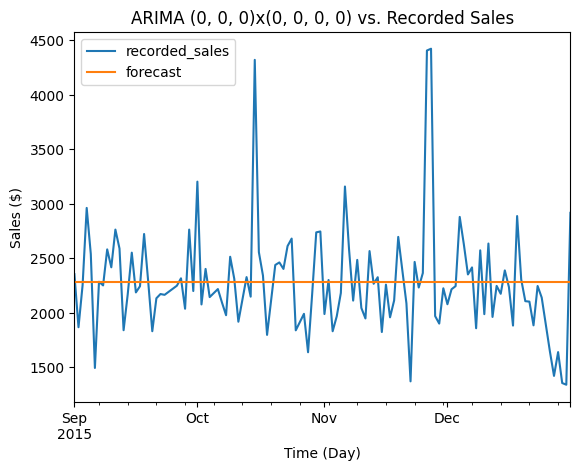

In [79]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast = pd.concat([test, predictions], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'ARIMA {model.order}x{model.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [76]:
# Create dictionary to store model orders and error metrics for comparison
scoring_dict = {}

# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)

# View numerical performance
scoring_dict['Model 1'] = (f'{model.order}x{model.seasonal_order} RMSE:{rmse.round(2)} MAE:{mae.round(2)}')
scoring_dict

{'Model 1': '(0, 0, 0)x(0, 0, 0, 0) RMSE:482.43 MAE:318.21'}

### Begin Fiddling with ARIMA model orders

In [72]:
# Create and fit the ARIMA model
model2 = ARIMA(endog=train, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), freq = 'D')
results2 = model2.fit()

In [73]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions2 = results2.predict(start = test.index[0], end = test.index[-1])
predictions2.sample(5)

2015-09-29    2282.123045
2015-12-13    2282.123045
2015-10-15    2282.123045
2015-10-02    2282.123045
2015-11-28    2282.123045
Name: predicted_mean, dtype: float64

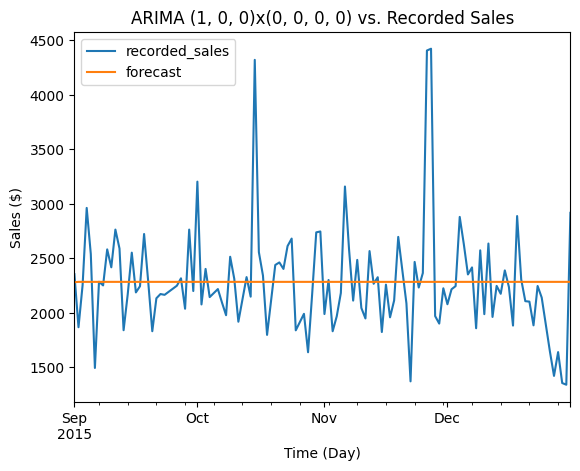

In [80]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast = pd.concat([test, predictions2], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'ARIMA {model2.order}x{model2.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [85]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test, predictions2))
mae = mean_absolute_error(test, predictions2)

# View numerical performance
scoring_dict['Model 2'] = (f'{model2.order}x{model2.seasonal_order} RMSE:{rmse.round(2)} MAE:{mae.round(2)}')
scoring_dict

{'Model 1': '(0, 0, 0)x(0, 0, 0, 0) RMSE:482.43 MAE:318.21',
 'Model 2': '(1, 0, 0)x(0, 0, 0, 0) RMSE:482.43 MAE:318.24',
 'Model 3': '(1, 0, 1)x(0, 0, 0, 0) RMSE:482.43 MAE:318.21'}

### Another

In [98]:
# Create and fit the ARIMA model
model3 = ARIMA(endog=train, order=(0, 0, 1), seasonal_order=(0, 0, 0, 0), freq = 'D')
results3 = model3.fit()

In [99]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions3 = results3.predict(start = test.index[0], end = test.index[-1])
predictions3.sample(5)

2015-12-31    2282.123046
2015-11-04    2282.123046
2015-11-11    2282.123046
2015-09-12    2282.123046
2015-12-23    2282.123046
Name: predicted_mean, dtype: float64

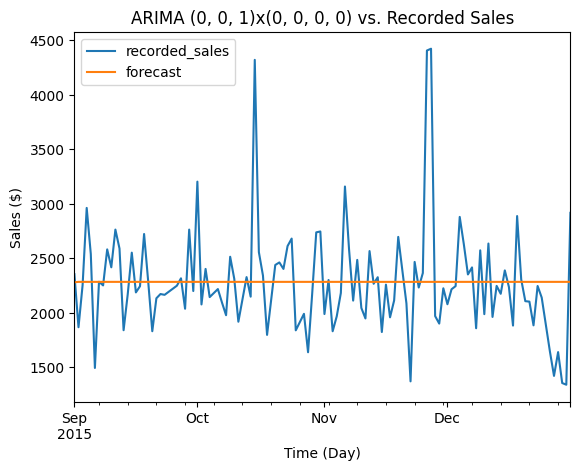

In [100]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast = pd.concat([test, predictions3], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'ARIMA {model3.order}x{model3.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [101]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test, predictions3))
mae = mean_absolute_error(test, predictions3)

# View numerical performance
scoring_dict['Model 3'] = (f'{model3.order}x{model3.seasonal_order} RMSE:{rmse.round(2)} MAE:{mae.round(2)}')
scoring_dict

{'Model 1': '(0, 0, 0)x(0, 0, 0, 0) RMSE:482.43 MAE:318.21',
 'Model 2': '(1, 0, 0)x(0, 0, 0, 0) RMSE:482.43 MAE:318.24',
 'Model 3': '(0, 0, 1)x(0, 0, 0, 0) RMSE:482.43 MAE:318.25',
 'Model 4': '(1, 0, 1)x(0, 0, 0, 7) RMSE:484.2 MAE:323.72'}

### Another

In [102]:
# Create and fit the ARIMA model
model4 = ARIMA(endog=train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0), freq = 'D')
results4 = model4.fit()

In [103]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions4 = results4.predict(start = test.index[0], end = test.index[-1])
predictions4.sample(5)

2015-10-17    2292.014994
2015-09-06    2411.020532
2015-09-03    2459.894250
2015-10-08    2294.034436
2015-10-25    2291.338674
Name: predicted_mean, dtype: float64

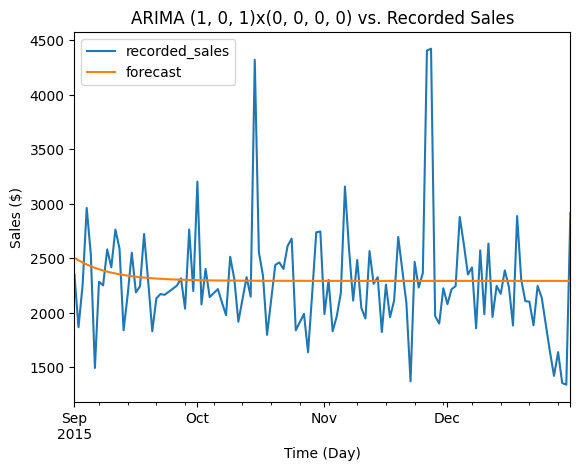

In [104]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast = pd.concat([test, predictions4], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'ARIMA {model4.order}x{model4.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [105]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test, predictions4))
mae = mean_absolute_error(test, predictions4)

# View numerical performance
scoring_dict['Model 4'] = (f'{model4.order}x{model4.seasonal_order} RMSE:{rmse.round(2)} MAE:{mae.round(2)}')
scoring_dict

{'Model 1': '(0, 0, 0)x(0, 0, 0, 0) RMSE:482.43 MAE:318.21',
 'Model 2': '(1, 0, 0)x(0, 0, 0, 0) RMSE:482.43 MAE:318.24',
 'Model 3': '(0, 0, 1)x(0, 0, 0, 0) RMSE:482.43 MAE:318.25',
 'Model 4': '(1, 0, 1)x(0, 0, 0, 0) RMSE:484.2 MAE:323.72'}

### Another

In [106]:
# Create and fit the ARIMA model
model5 = ARIMA(endog=train, order=(0, 0, 0), seasonal_order=(1, 0, 0, 7), freq = 'D')
results5 = model5.fit()

In [107]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions5 = results5.predict(start = test.index[0], end = test.index[-1])
predictions5.sample(5)

2015-12-30    2282.123042
2015-09-28    2277.928831
2015-11-30    2282.122344
2015-09-15    2264.362310
2015-10-13    2281.752013
Name: predicted_mean, dtype: float64

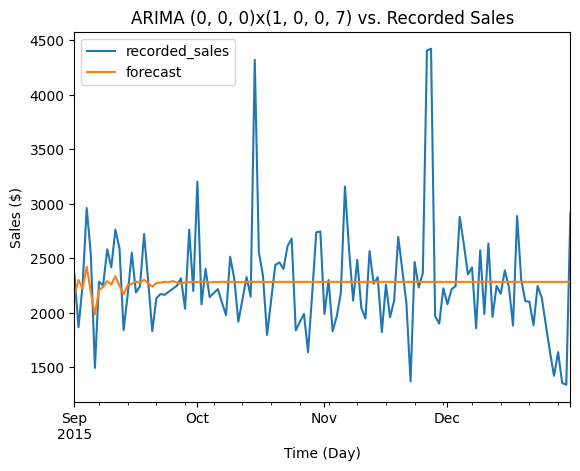

In [108]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast = pd.concat([test, predictions5], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'ARIMA {model5.order}x{model5.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [109]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test, predictions5))
mae = mean_absolute_error(test, predictions5)

# View numerical performance
scoring_dict['Model 5'] = (f'{model5.order}x{model5.seasonal_order} RMSE:{rmse.round(2)} MAE:{mae.round(2)}')
scoring_dict

{'Model 1': '(0, 0, 0)x(0, 0, 0, 0) RMSE:482.43 MAE:318.21',
 'Model 2': '(1, 0, 0)x(0, 0, 0, 0) RMSE:482.43 MAE:318.24',
 'Model 3': '(0, 0, 1)x(0, 0, 0, 0) RMSE:482.43 MAE:318.25',
 'Model 4': '(1, 0, 1)x(0, 0, 0, 0) RMSE:484.2 MAE:323.72',
 'Model 5': '(0, 0, 0)x(1, 0, 0, 7) RMSE:477.24 MAE:315.48'}

### Another

In [111]:
# Create and fit the ARIMA model
model6 = ARIMA(endog=train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), freq = 'D')
results6 = model6.fit()

In [114]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions6 = results6.predict(start = test.index[0], end = test.index[-1])
predictions6.sample(5)

2015-11-26    2279.988319
2015-12-03    2279.714483
2015-10-17    2393.266181
2015-12-07    2255.319403
2015-09-03    2345.211255
Name: predicted_mean, dtype: float64

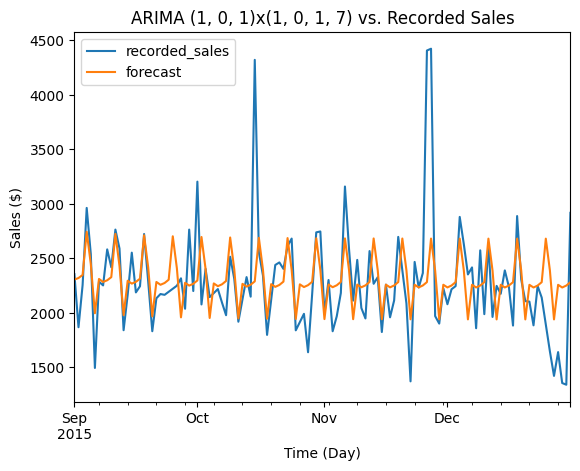

In [115]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast = pd.concat([test, predictions6], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'ARIMA {model6.order}x{model6.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [116]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test, predictions6))
mae = mean_absolute_error(test, predictions6)

# View numerical performance
scoring_dict['Model 6'] = (f'{model6.order}x{model6.seasonal_order} RMSE:{rmse.round(2)} MAE:{mae.round(2)}')
scoring_dict

{'Model 1': '(0, 0, 0)x(0, 0, 0, 0) RMSE:482.43 MAE:318.21',
 'Model 2': '(1, 0, 0)x(0, 0, 0, 0) RMSE:482.43 MAE:318.24',
 'Model 3': '(0, 0, 1)x(0, 0, 0, 0) RMSE:482.43 MAE:318.25',
 'Model 4': '(1, 0, 1)x(0, 0, 0, 0) RMSE:484.2 MAE:323.72',
 'Model 5': '(0, 0, 0)x(1, 0, 0, 7) RMSE:477.24 MAE:315.48',
 'Model 6': '(1, 0, 1)x(1, 0, 1, 7) RMSE:433.04 MAE:273.21'}

# GRIDSEARCH TIME NEEDS WORK

In [117]:
# Custom wrapper for ARIMA model to use with scikit-learn's GridSearchCV
class ARIMAWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None

    def fit(self, X, y):
        self.model = ARIMA(endog=y, order=self.order, seasonal_order=self.seasonal_order)
        self.model_fit = self.model.fit()
        return self

    def predict(self, X):
        return self.model_fit.forecast(steps=len(X))

In [120]:
# Create a smaller parameter grid
param_grid = {
    'order': [(p, 0, q) for p in range(1, 3) for q in range(1, 3)],
    'seasonal_order': [(P, D, Q, S) for P in range(1, 3) for D in range(0, 2) for Q in range(1, 3) for S in [0, 7]]
}

# Initialize the GridSearchCV
grid = GridSearchCV(estimator=ARIMAWrapper(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Fit to the data
grid.fit(train.index, train)

# Summary of the best model
print(f'Best ARIMA{grid.best_params_["order"]}x{grid.best_params_["seasonal_order"]} model - MSE:{-grid.best_score_}')

# Predicting and calculating MSE
y_pred = grid.best_estimator_.predict(test)
mae = mean_absolute_error(test, y_pred)
rmse = sqrt(mean_squared_error(test, y_pred))

print(f'Mean Absolute Error (MSE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best ARIMA(1, 0, 2)x(1, 0, 2, 7) model - MSE:109931.06481033076
Mean Absolute Error (MSE): 273.1777686062062
Root Mean Squared Error (RMSE): 433.22175424990473


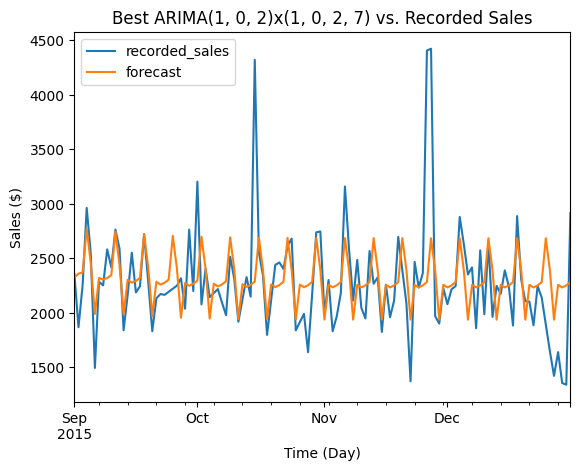

In [121]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast = pd.concat([test, y_pred], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'Best ARIMA{grid.best_params_["order"]}x{grid.best_params_["seasonal_order"]} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

### Baseline Comparison
Your model's performance means only so much on its own. Often we find ourselves needing to know how well our model has done *compared to* the current model, or compared to some baseline. Here we explore different baselines and see what their error metrics are like.

In [25]:
# Generating Seasonal Naive Forecast
seasonal_naive_forecast = test.shift(7)

# Remove NaN values produced by the shift operation
seasonal_naive_forecast.dropna(inplace=True)

In [26]:
rmse = np.sqrt(mean_squared_error(test[7:], seasonal_naive_forecast))
mae = mean_absolute_error(test[7:], seasonal_naive_forecast)
rmse, mae

(580.5303153526767, 370.5682608695652)

In [27]:
noise = np.random.uniform(-455, 455, size = len(seasonal_naive_forecast))
noisy_seasonal_naive_forecast = seasonal_naive_forecast + noise

rmse = np.sqrt(mean_squared_error(test[7:], noisy_seasonal_naive_forecast))
mae = mean_absolute_error(test[7:], noisy_seasonal_naive_forecast)
rmse, mae

(656.9773129207719, 463.96541185633504)

In [28]:
# Calculate residuals
residuals = test[7:] - seasonal_naive_forecast

# Determine their standard deviation
natural_variability = residuals.std()

In [29]:
natural_variability

582.2469550285081

In [30]:
noise = np.random.uniform(-natural_variability, natural_variability, size = len(seasonal_naive_forecast))
noisy_seasonal_naive_forecast = seasonal_naive_forecast + noise

rmse = np.sqrt(mean_squared_error(test[7:], noisy_seasonal_naive_forecast))
mae = mean_absolute_error(test[7:], noisy_seasonal_naive_forecast)
rmse, mae

(638.218112021568, 444.2148610797599)

In [31]:
(568.8026191083292, 367.2661815068493)

(568.8026191083292, 367.2661815068493)

In [32]:
noise_dates = []
us_holidays = holidays.UnitedStates(years=2015)
for date, name in sorted(us_holidays.items()):
    print(f"{date}: {name}")
    noise_dates.append(date)

2015-01-01: New Year's Day
2015-01-19: Martin Luther King Jr. Day
2015-02-16: Washington's Birthday
2015-05-25: Memorial Day
2015-07-03: Independence Day (Observed)
2015-07-04: Independence Day
2015-09-07: Labor Day
2015-10-12: Columbus Day
2015-11-11: Veterans Day
2015-11-26: Thanksgiving
2015-12-25: Christmas Day


In [33]:
dummy_model = seasonal_naive_forecast.copy()

In [34]:
def boost_sales_on_holidays(data, holiday_list, coefficient):
    # Filter holidays from September onward
    holiday_list = [date for date in holiday_list if date >= datetime.date(2015, 9, 1)]
    
    # Convert the list to a Pandas datetime format for easier comparison
    holiday_list = pd.to_datetime(holiday_list)
    
    # Boost the 'sales' column by 50% where the date matches a holiday
    data.loc[data.index.isin(holiday_list)] *= 1.5

In [35]:
# Apply the boost to the DataFrame
boost_sales_on_holidays(dummy_model, noise_dates, 1.5)

In [36]:
dummy_model, seasonal_naive_forecast

(order_date
 2015-09-08    2352.85
 2015-09-09    1865.55
 2015-09-10    2252.60
 2015-09-11    2960.95
 2015-09-12    2537.80
                ...   
 2015-12-27    2104.90
 2015-12-28    2100.70
 2015-12-29    1882.95
 2015-12-30    2244.30
 2015-12-31    2137.85
 Name: total_price, Length: 115, dtype: float64,
 order_date
 2015-09-08    2352.85
 2015-09-09    1865.55
 2015-09-10    2252.60
 2015-09-11    2960.95
 2015-09-12    2537.80
                ...   
 2015-12-27    2104.90
 2015-12-28    2100.70
 2015-12-29    1882.95
 2015-12-30    2244.30
 2015-12-31    2137.85
 Name: total_price, Length: 115, dtype: float64)

<Axes: xlabel='order_date'>

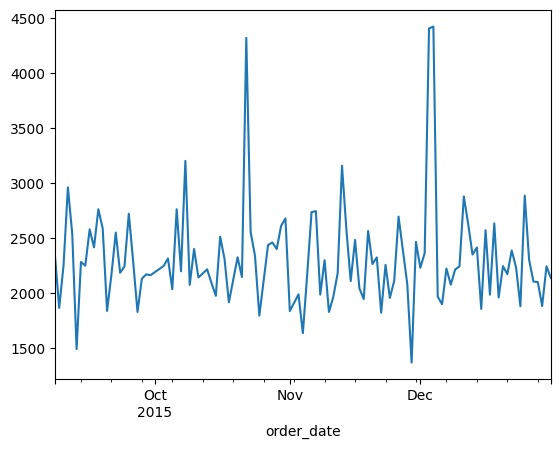

In [37]:
seasonal_naive_forecast.plot()

<Axes: xlabel='order_date'>

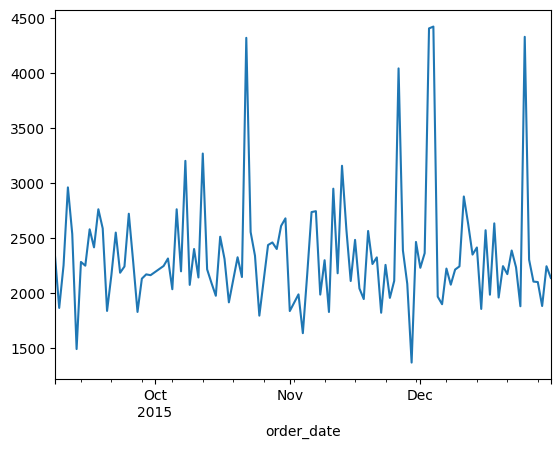

In [38]:
dummy_model.plot()

<Axes: xlabel='order_date'>

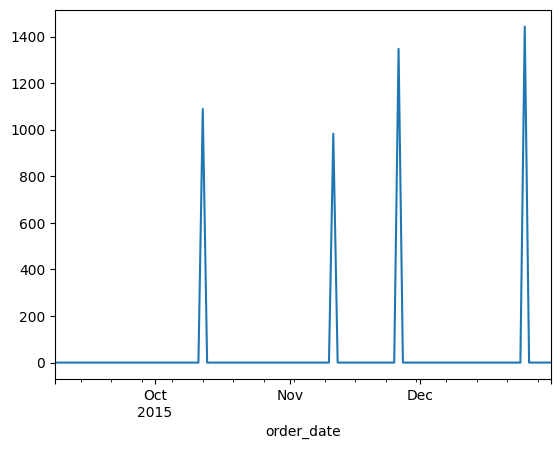

In [39]:
difference = dummy_model - seasonal_naive_forecast
difference.plot()

In [40]:
rmse = np.sqrt(mean_squared_error(test[7:], dummy_model))
mae = mean_absolute_error(test[7:], dummy_model)
rmse, mae

(613.1687445913645, 389.42293478260865)